In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [18]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

In [19]:
tf.keras.datasets.cifar10.load_data?

Signature: tf.keras.datasets.cifar10.load_data()
Docstring:
Loads the CIFAR10 dataset.

This is a dataset of 50,000 32x32 color training images and 10,000 test
images, labeled over 10 categories. See more info at the
[CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html).

The classes are:

| Label | Description |
|:-----:|-------------|
|   0   | airplane    |
|   1   | automobile  |
|   2   | bird        |
|   3   | cat         |
|   4   | deer        |
|   5   | dog         |
|   6   | frog        |
|   7   | horse       |
|   8   | ship        |
|   9   | truck       |

Returns:
  Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

**x_train**: uint8 NumPy array of grayscale image data with shapes
  `(50000, 32, 32, 3)`, containing the training data. Pixel values range
  from 0 to 255.

**y_train**: uint8 NumPy array of labels (integers in range 0-9)
  with shape `(50000, 1)` for the training data.

**x_test**: uint8 NumPy array of grayscale image data with shape

In [20]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

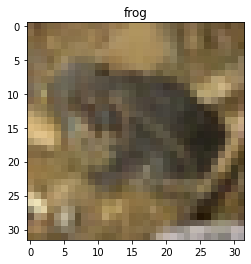

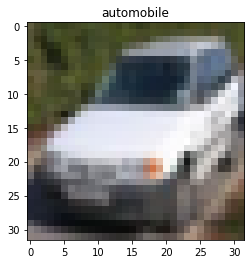

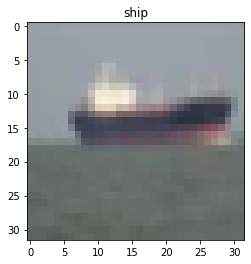

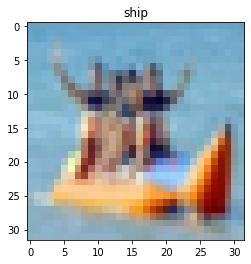

In [21]:
num = 23
for i in range(4):
    img, label = train_x[(i+1) * num],  train_y[(i+1) * num]
    plt.title(classes[int(label)])
    plt.imshow(img)
    plt.show()

In [22]:
train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

In [23]:
for i in (train_x, test_x, train_y, test_y):
    print(i.shape, i.dtype)


(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


In [24]:
NUM_EPOCHS = 15
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [25]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.batch_norm = tf.keras.layers.BatchNormalization()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = self.max_pool(out)
        out = self.batch_norm(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

In [26]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [27]:
learning_rate = 0.001

# optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# writer = tf.summary.create_file_writer('logs/sgd')
writer = tf.summary.create_file_writer('logs/adam')

In [28]:
def accuracy_on_test(model):
    accuracy_value = []
    number_of_splits = 10
    test_x_split = tf.split(test_x, 10)
    test_y_split = tf.split(test_y, 10)

    for i in range(number_of_splits):
        test_logits = model(test_x_split[i])
        accuracy_value.append(accuracy(test_logits, test_y_split[i]).numpy())
    return np.mean(accuracy_value)

In [29]:
%%time

for iteration, (images, labels) in enumerate(train_ds):


    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if iteration % 6000 == 0 and iteration != 0:

        learning_rate = learning_rate / 3
        print(f'Learning rate now: {learning_rate}')
        optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Calc and display loss/accuracy
    if iteration % 400 == 0:

        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))

        
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)
            tf.summary.scalar('accuracy_on_test', accuracy_on_test(model), iteration)


[   0] Accuracy: 10.16 %
[ 400] Accuracy: 56.25 %
[ 800] Accuracy: 66.02 %
[1200] Accuracy: 70.70 %
[1600] Accuracy: 73.44 %
[2000] Accuracy: 72.27 %
[2400] Accuracy: 76.56 %
[2800] Accuracy: 75.39 %
[3200] Accuracy: 74.61 %
[3600] Accuracy: 73.44 %
[4000] Accuracy: 76.95 %
[4400] Accuracy: 76.56 %
[4800] Accuracy: 76.17 %
[5200] Accuracy: 77.73 %
[5600] Accuracy: 77.73 %
Learning rate now: 0.0003333333333333333
[6000] Accuracy: 75.00 %
[6400] Accuracy: 78.52 %
[6800] Accuracy: 77.73 %
[7200] Accuracy: 76.56 %
[7600] Accuracy: 77.34 %
[8000] Accuracy: 78.12 %
[8400] Accuracy: 78.91 %
[8800] Accuracy: 78.12 %
[9200] Accuracy: 78.52 %
[9600] Accuracy: 77.73 %
[10000] Accuracy: 79.30 %
[10400] Accuracy: 78.12 %
[10800] Accuracy: 78.91 %
[11200] Accuracy: 77.73 %
[11600] Accuracy: 77.73 %
Wall time: 4min 14s


In [30]:
%%time
accuracy_value = []
number_of_splits = 10
test_x_split = tf.split(test_x, 10)
test_y_split = tf.split(test_y, 10)

for i in range(number_of_splits):
    test_logits = model(test_x_split[i])
    accuracy_value.append(accuracy(test_logits, test_y_split[i]).numpy())

print("Final Accuracy: %5.2f %%" % (np.mean(accuracy_value) * 100))

Final Accuracy: 77.99 %
Wall time: 806 ms


In [31]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:])
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

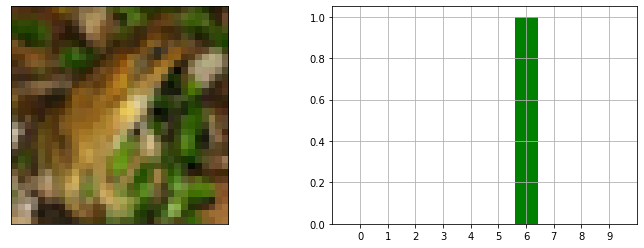

Predicted: 6
True Answer: 6


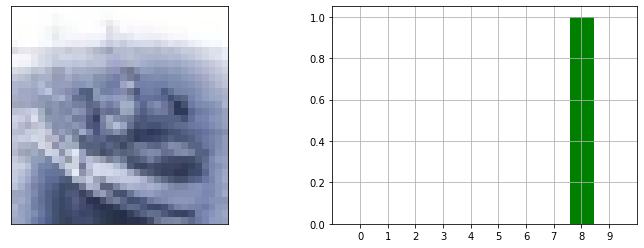

Predicted: 8
True Answer: 8


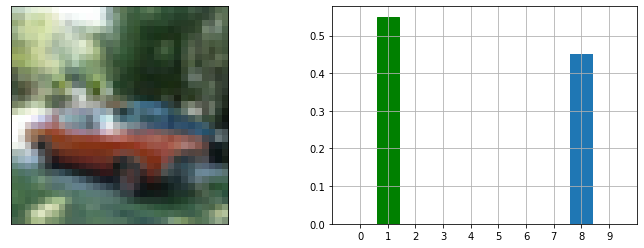

Predicted: 1
True Answer: 1


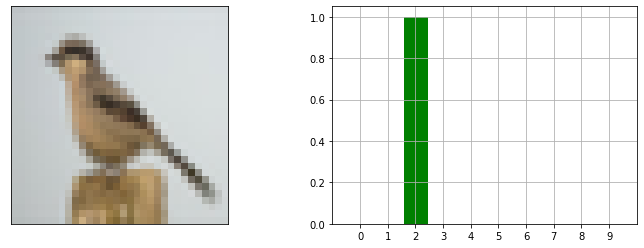

Predicted: 2
True Answer: 2


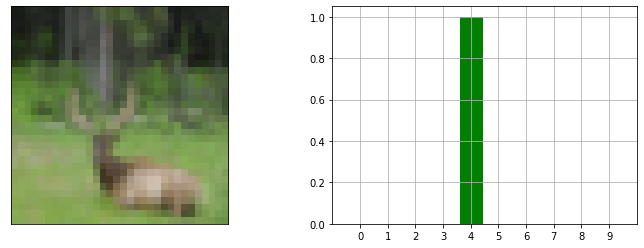

Predicted: 4
True Answer: 4


In [32]:
import random
for i in range(5):
    idx = random.randint(0, test_x.shape[0])
    sample = test_x[idx, ...]
    test_item(sample)

    print('True Answer: {}'.format(test_y[idx]))